In [39]:
import os

import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import xarray as xr

import jaxparrow.cyclogeostrophy as cyclo
import jaxparrow.geostrophy as geost
import jaxparrow.tools.geometry as geo

%reload_ext autoreload
%autoreload 2

# Reading data

## Parameters

In [40]:
dir_data = "data"
name_mask = "mask_eNATL60MEDWEST_3.6.nc"
name_coord = "coordinates_eNATL60MEDWEST.nc"
name_ssh = "eNATL60MEDWEST-BLB002_y2009m07d01.1h_sossheig.nc"
name_u = "eNATL60MEDWEST-BLB002_y2009m07d01.1h_sozocrtx.nc"
name_v = "eNATL60MEDWEST-BLB002_y2009m07d01.1h_somecrty.nc"

## Opening data

In [41]:
ds_coord = xr.open_dataset(os.path.join(dir_data, name_coord))
lon = ds_coord.nav_lon.values
lat = ds_coord.nav_lat.values

ds_mask = xr.open_dataset(os.path.join(dir_data, name_mask))
mask_ssh = ds_mask.tmask[0,0].values
mask_u = ds_mask.umask[0,0].values
mask_v = ds_mask.vmask[0,0].values

ds_ssh = xr.open_dataset(os.path.join(dir_data, name_ssh))
lon_ssh = ds_ssh.nav_lon.values
lat_ssh = ds_ssh.nav_lat.values
ssh = ds_ssh.sossheig[0].values

ds_u = xr.open_dataset(os.path.join(dir_data, name_u))
lon_u = ds_u.nav_lon.values
lat_u = ds_u.nav_lat.values
uvel = ds_u.sozocrtx[0].values

ds_v = xr.open_dataset(os.path.join(dir_data, name_v))
lon_v = ds_v.nav_lon.values
lat_v = ds_v.nav_lat.values
vvel = ds_v.somecrty[0].values

In [42]:
mask_u = 1 - mask_u
mask_v = 1 - mask_v
mask_ssh = 1- mask_ssh

In [43]:
uvel = ma.masked_array(uvel, mask_u)
vvel = ma.masked_array(vvel, mask_v)
ssh = ma.masked_array(ssh, mask_ssh)

In [44]:
lon_u = ma.masked_array(lon_u, mask_u)
lat_u = ma.masked_array(lat_u, mask_u)
lon_v = ma.masked_array(lon_v, mask_v)
lat_v = ma.masked_array(lat_v, mask_v)
lon_ssh = ma.masked_array(lon_ssh, mask_ssh)
lat_ssh = ma.masked_array(lat_ssh, mask_ssh)

## Create arrays of spatial steps

These dx and dy steps must be used to compute derivatives.

In [45]:
dx_ssh, dy_ssh = geo.compute_spatial_step(lat_ssh, lon_ssh)
dx_u, dy_u = geo.compute_spatial_step(lat_u, lon_u)
dx_v, dy_v = geo.compute_spatial_step(lat_v, lon_v)

# Input data

In [46]:
coriolis_factor_u = geo.compute_coriolis_factor(lat_u)
coriolis_factor_v = geo.compute_coriolis_factor(lat_v)

# Geostrophic balance

In [47]:
u_geos, v_geos = geost.geostrophy(ssh, dx_ssh, dy_ssh, coriolis_factor_u, coriolis_factor_v)

In [48]:
u_geos = ma.masked_array(u_geos, mask_u)
v_geos = ma.masked_array(v_geos, mask_v)

# Cyclogeostrophic balance

## Defining the cost function

In [49]:
# Initial loss
cyclo._loss(u_geos.filled(0), v_geos.filled(0), u_geos.filled(0), v_geos.filled(0), dx_u, dx_v, dy_u, dy_v, coriolis_factor_u.filled(1), coriolis_factor_v.filled(1))

Array(1017.6416, dtype=float32)

## Computing the cyclogeostrophy - Minimization method

In [50]:
# run gradient descent to minimize f
u_min, v_min = cyclo.variational(u_geos, v_geos, dx_u, dx_v, dy_u, dy_v, coriolis_factor_u, coriolis_factor_v, n_it=int(2e3))

100%|██████████| 2000/2000 [00:18<00:00, 105.96it/s]


In [51]:
cyclo._loss(u_geos.filled(0), v_geos.filled(0), u_min, v_min, dx_u, dx_v, dy_u, dy_v, coriolis_factor_u.filled(1), coriolis_factor_v.filled(1))

Array(5.925002, dtype=float32)

In [52]:
u_min = ma.masked_array(u_min, mask_u)
v_min = ma.masked_array(v_min, mask_v)

## Computing the cyclogeostrophy - Iterative method

### Penven: no conv filter

#### Unconstrained initial residual

In [140]:
u_it, v_it, errsq_hist, losses = cyclo.iterative(u_geos.filled(0), v_geos.filled(0), lat_u, lat_v, lon_u, lon_v, coriolis_factor_u.filled(1), coriolis_factor_v.filled(1),
                                                 n_it=10, run_inspection=True)

100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


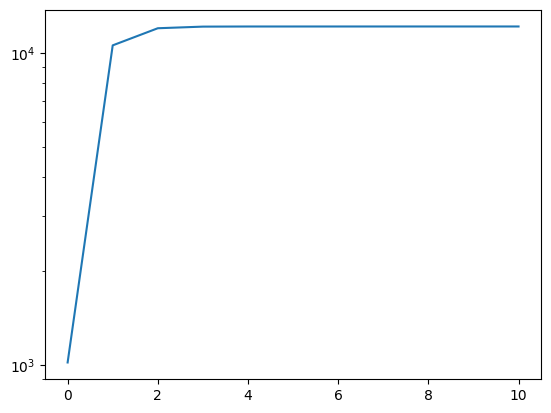

In [141]:
plt.semilogy(losses)
plt.show()

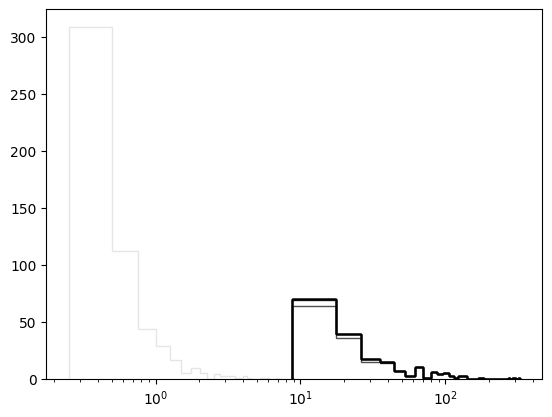

In [142]:
alphas = np.linspace(1e-7, .7, num=len(errsq_hist))**(1/7)
for i in range(len(errsq_hist)):
    plt.stairs(errsq_hist[i][0][1:], errsq_hist[i][1][1:], color="black", alpha=alphas[i])
plt.xscale('log')

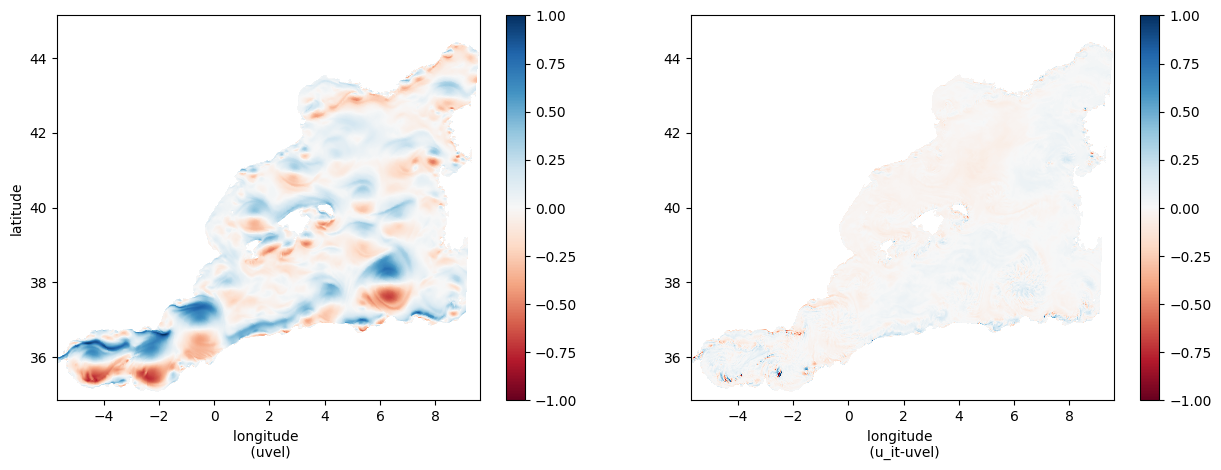

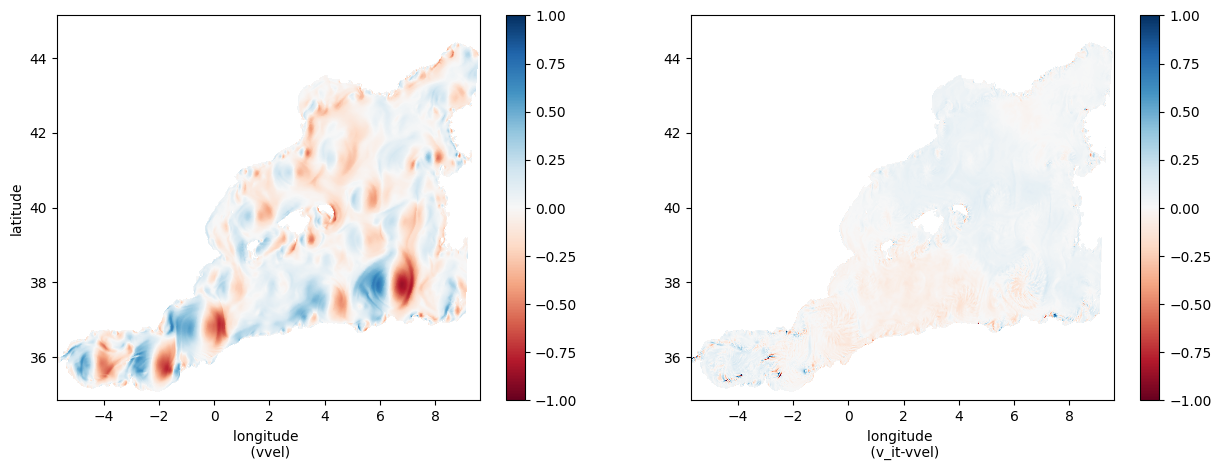

In [143]:
u_it = ma.masked_array(u_it, mask_u)
v_it = ma.masked_array(v_it, mask_v)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_it-uvel)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_it-uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_it-vvel)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_it-vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

#### Constrained initial residual

##### Constant value

In [144]:
u_it, v_it, errsq_hist, losses = cyclo.iterative(u_geos.filled(0), v_geos.filled(0), lat_u, lat_v, lon_u, lon_v, coriolis_factor_u.filled(1), coriolis_factor_v.filled(1),
                                                 n_it=10, errsq_init=1, run_inspection=True)

100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


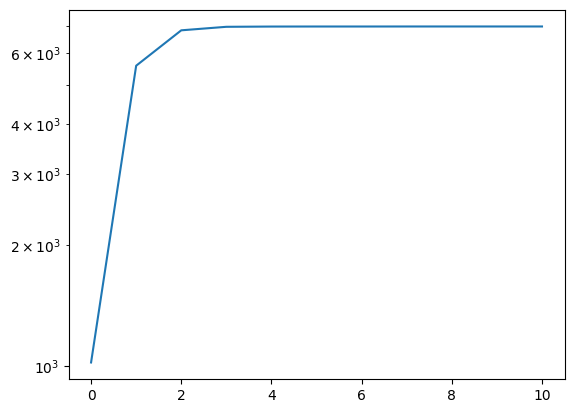

In [145]:
plt.semilogy(losses)
plt.show()

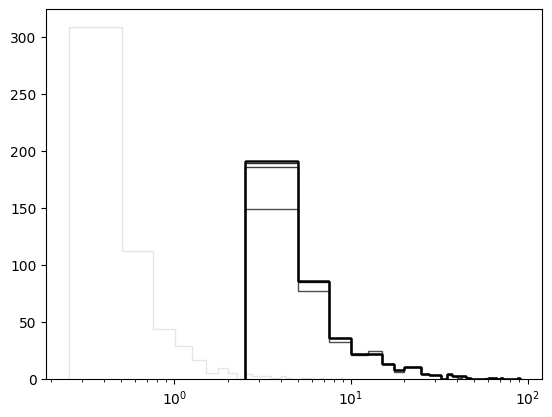

In [146]:
alphas = np.linspace(1e-7, .7, num=len(errsq_hist))**(1/7)
for i in range(len(errsq_hist)):
    plt.stairs(errsq_hist[i][0][1:], errsq_hist[i][1][1:], color="black", alpha=alphas[i])
plt.xscale('log')

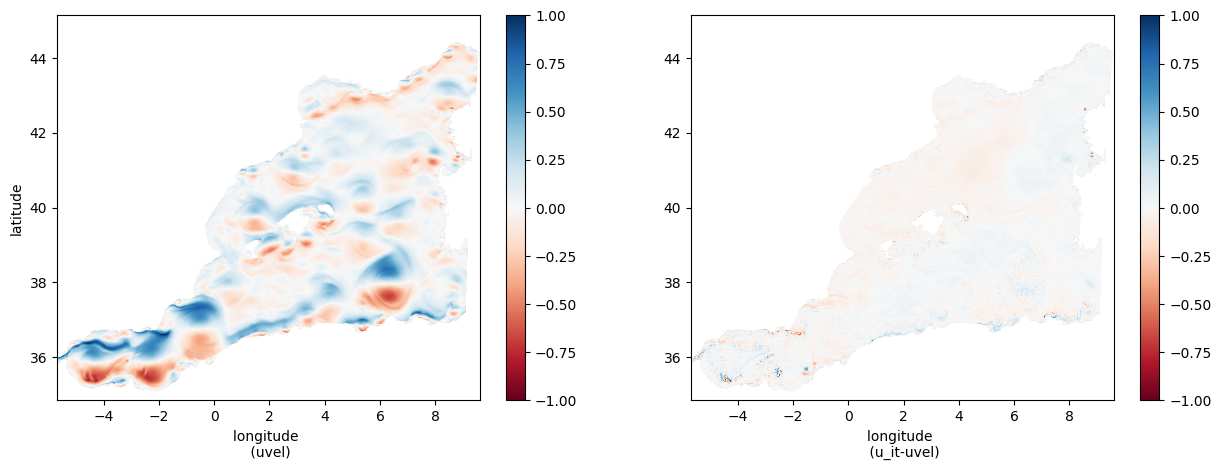

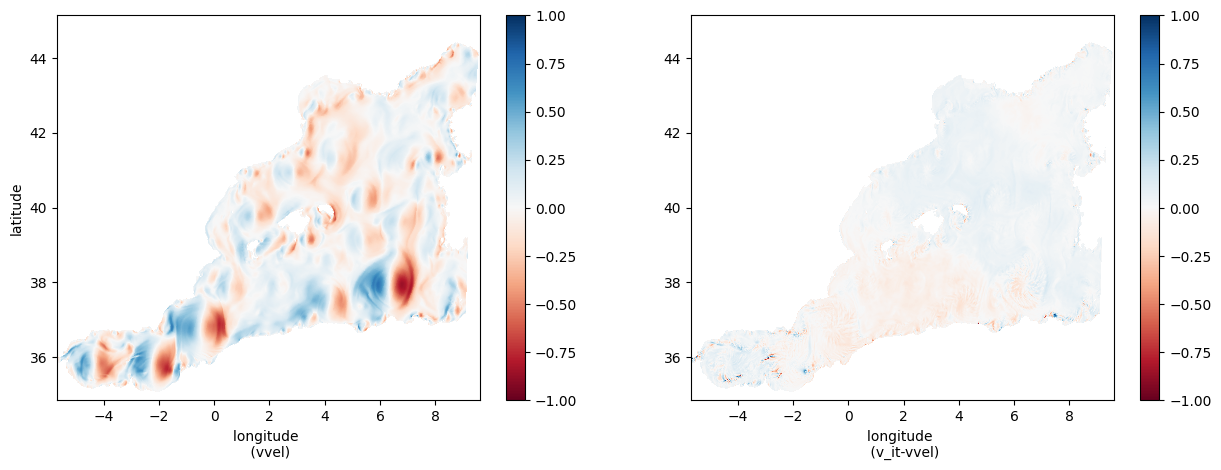

In [147]:
u_it = ma.masked_array(u_it, mask_u)
v_it = ma.masked_array(v_it, mask_v)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_it-uvel)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_it-uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_it-vvel)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_it-vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

##### Proportional to the geostrophic velocities

In [148]:
u_it, v_it, errsq_hist, losses = cyclo.iterative(u_geos.filled(0), v_geos.filled(0), lat_u, lat_v, lon_u, lon_v, coriolis_factor_u.filled(1), coriolis_factor_v.filled(1),
                                                 n_it=10, errsq_init="proportional", run_inspection=True)

100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


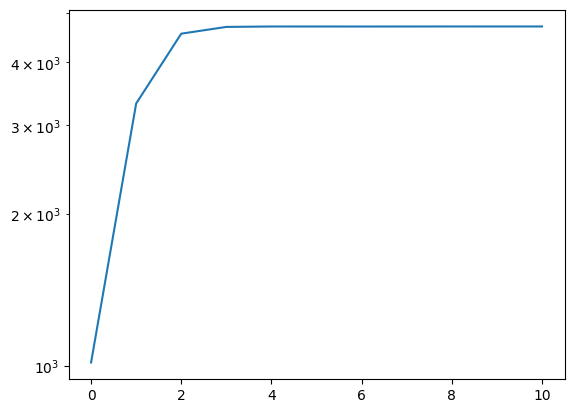

In [149]:
plt.semilogy(losses)
plt.show()

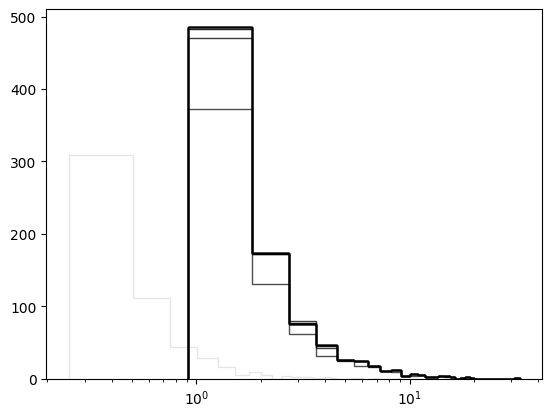

In [150]:
alphas = np.linspace(1e-7, .7, num=len(errsq_hist))**(1/7)
for i in range(len(errsq_hist)):
    plt.stairs(errsq_hist[i][0][1:], errsq_hist[i][1][1:], color="black", alpha=alphas[i])
plt.xscale('log')

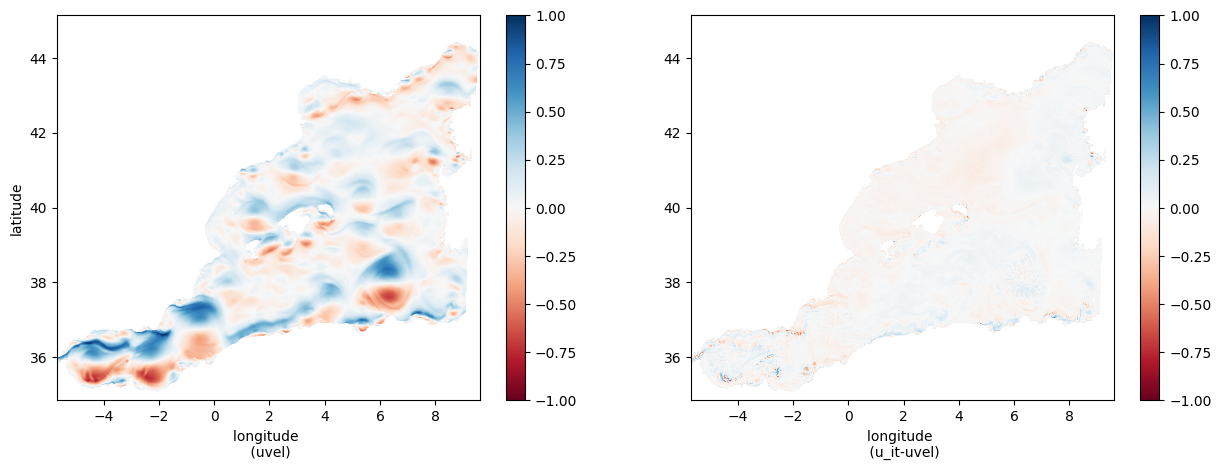

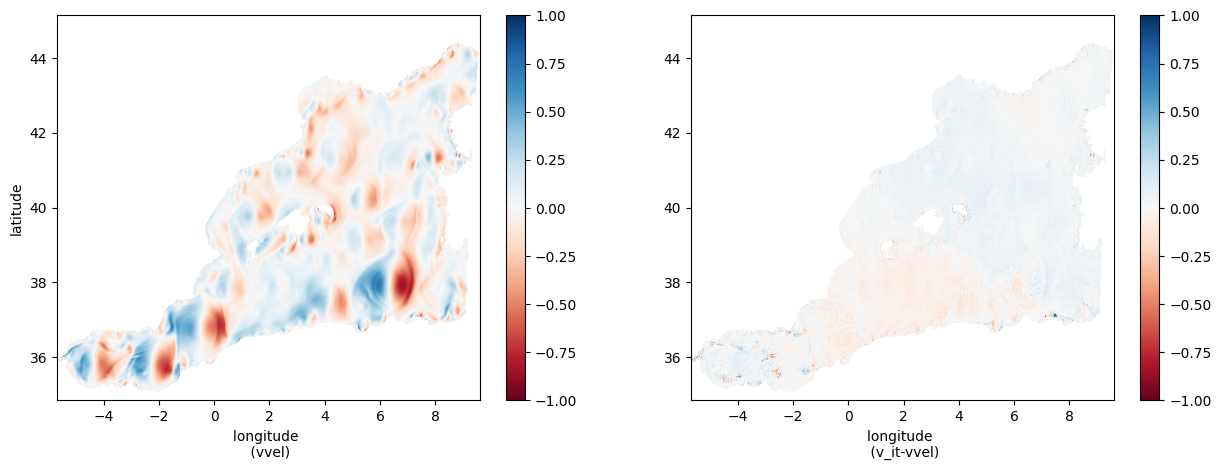

In [151]:
u_it = ma.masked_array(u_it, mask_u)
v_it = ma.masked_array(v_it, mask_v)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_it-uvel)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_it-uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_it-vvel)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_it-vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

### Ioannou: 3x3 conv filter

#### Unconstrained initial residual

In [152]:
u_it, v_it, errsq_hist, losses = cyclo.iterative(u_geos.filled(0), v_geos.filled(0), lat_u, lat_v, lon_u, lon_v, coriolis_factor_u.filled(1), coriolis_factor_v.filled(1),
                                                 n_it=10, err_filter_size=3, run_inspection=True)

100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


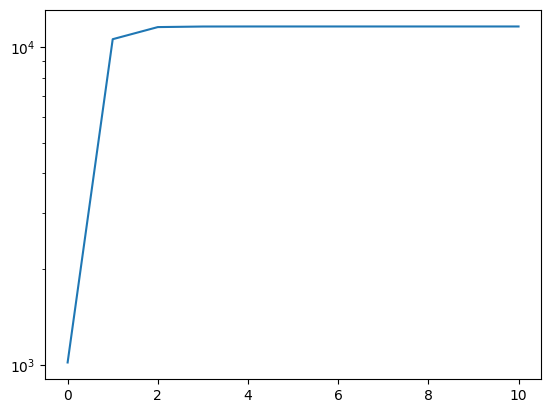

In [153]:
plt.semilogy(losses)
plt.show()

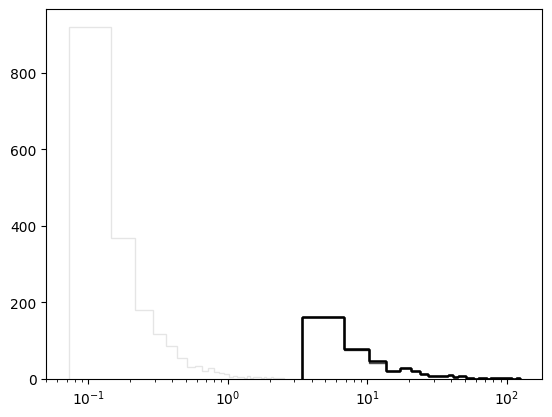

In [154]:
alphas = np.linspace(1e-7, .7, num=len(errsq_hist))**(1/7)
for i in range(len(errsq_hist)):
    plt.stairs(errsq_hist[i][0][1:], errsq_hist[i][1][1:], color="black", alpha=alphas[i])
plt.xscale('log')

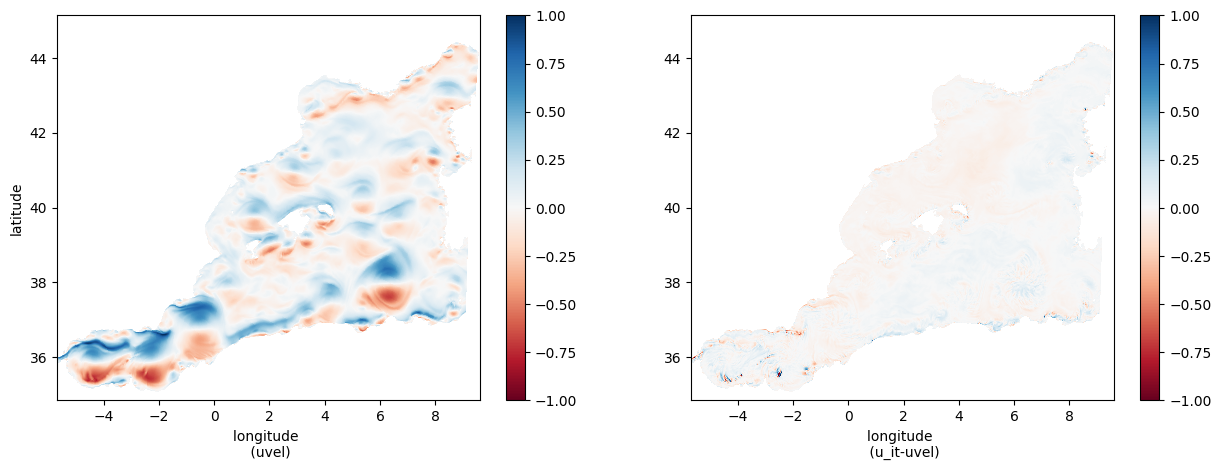

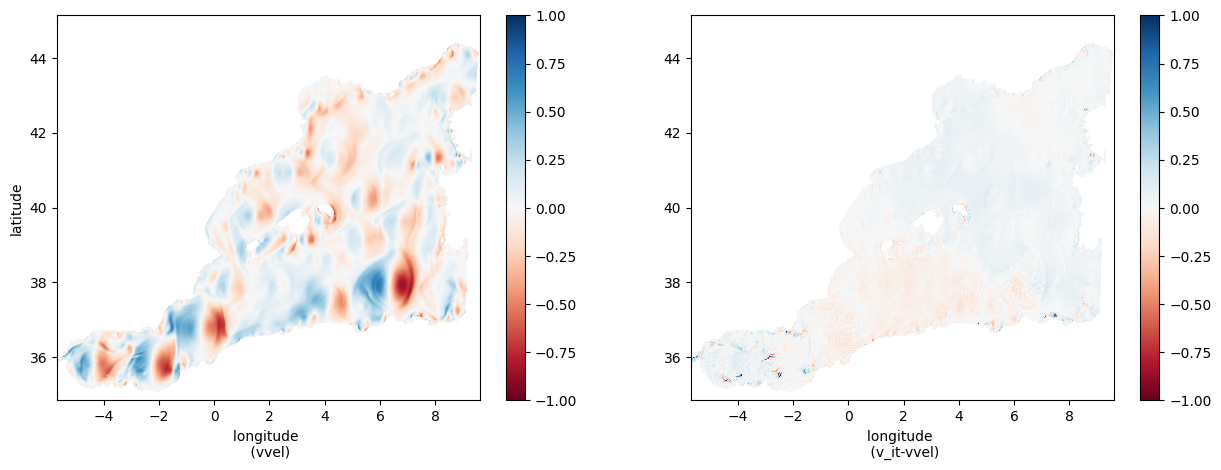

In [155]:
u_it = ma.masked_array(u_it, mask_u)
v_it = ma.masked_array(v_it, mask_v)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_it-uvel)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_it-uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_it-vvel)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_it-vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

#### Constrained initial residual

##### Constant value

In [156]:
u_it, v_it, errsq_hist, losses = cyclo.iterative(u_geos.filled(0), v_geos.filled(0), lat_u, lat_v, lon_u, lon_v, coriolis_factor_u.filled(1), coriolis_factor_v.filled(1),
                                                 n_it=10, errsq_init=1, err_filter_size=3, run_inspection=True)

100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


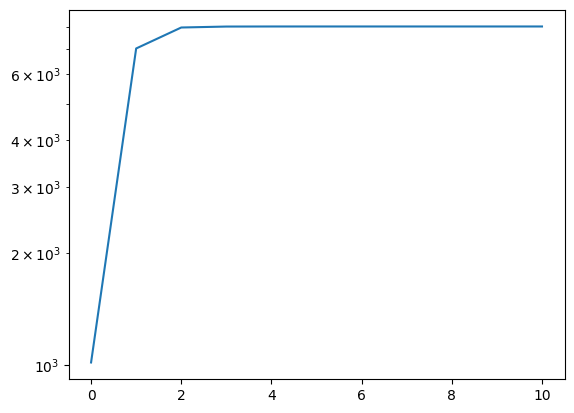

In [157]:
plt.semilogy(losses)
plt.show()

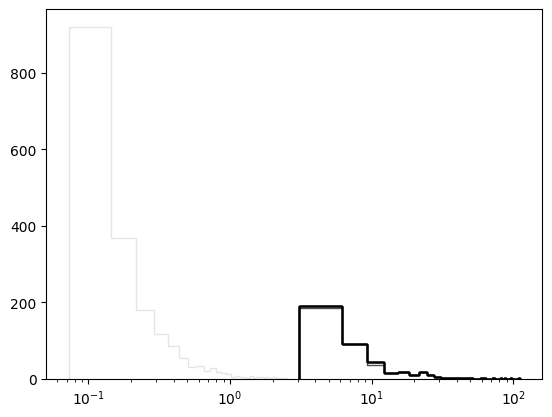

In [158]:
alphas = np.linspace(1e-7, .7, num=len(errsq_hist))**(1/7)
for i in range(len(errsq_hist)):
    plt.stairs(errsq_hist[i][0][1:], errsq_hist[i][1][1:], color="black", alpha=alphas[i])
plt.xscale('log')

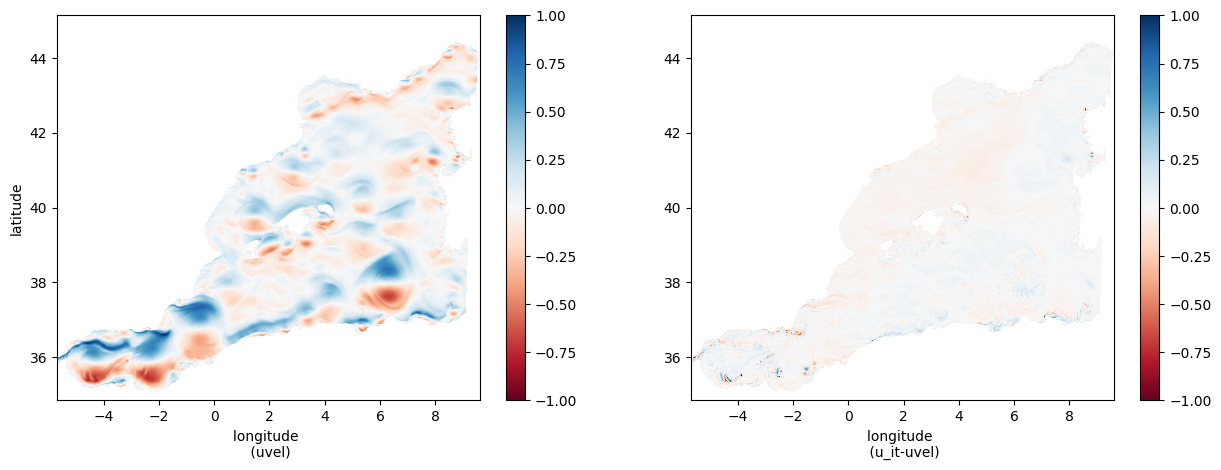

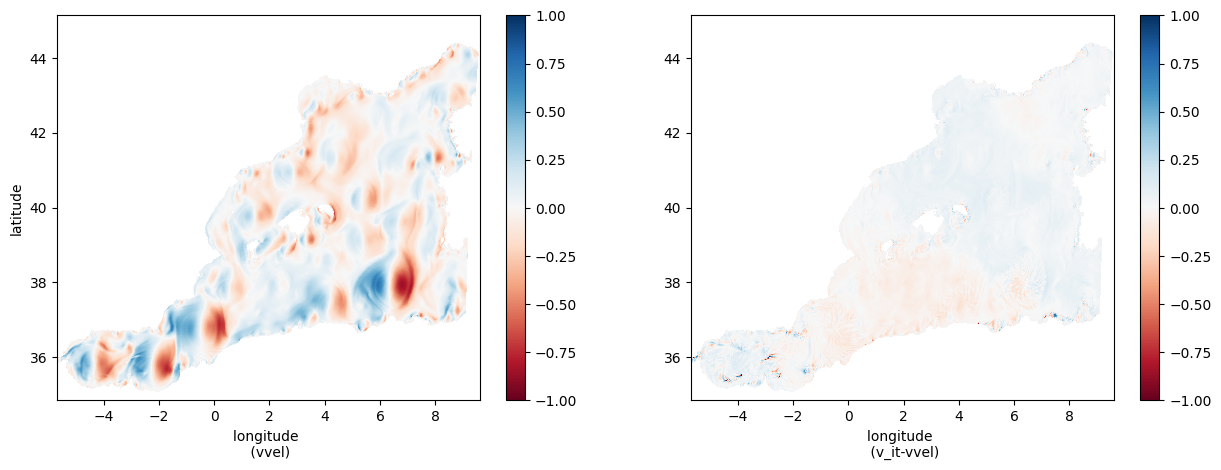

In [159]:
u_it = ma.masked_array(u_it, mask_u)
v_it = ma.masked_array(v_it, mask_v)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_it-uvel)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_it-uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_it-vvel)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_it-vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

##### Proportional to the geostrophic velocities

In [160]:
u_it, v_it, errsq_hist, losses = cyclo.iterative(u_geos.filled(0), v_geos.filled(0), lat_u, lat_v, lon_u, lon_v, coriolis_factor_u.filled(1), coriolis_factor_v.filled(1),
                                                 n_it=10, errsq_init="proportional", err_filter_size=3, run_inspection=True)

100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


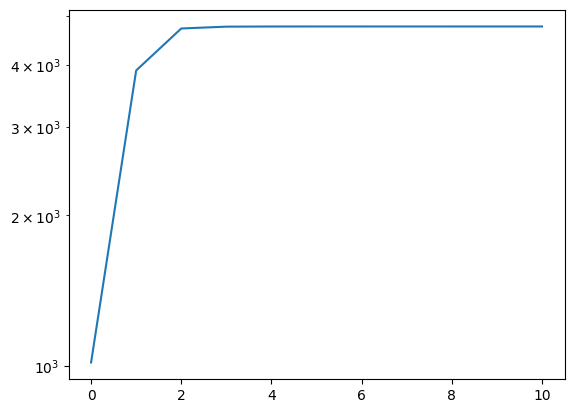

In [161]:
plt.semilogy(losses)
plt.show()

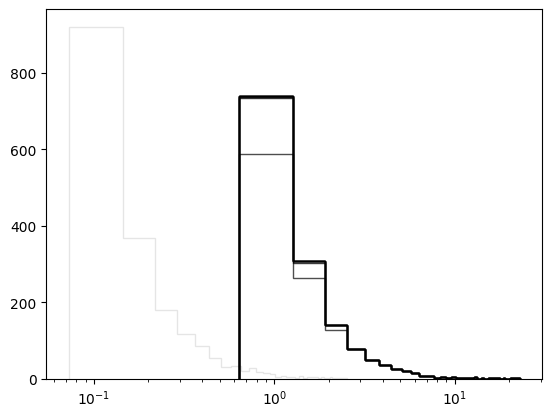

In [162]:
alphas = np.linspace(1e-7, .7, num=len(errsq_hist))**(1/7)
for i in range(len(errsq_hist)):
    plt.stairs(errsq_hist[i][0][1:], errsq_hist[i][1][1:], color="black", alpha=alphas[i])
plt.xscale('log')

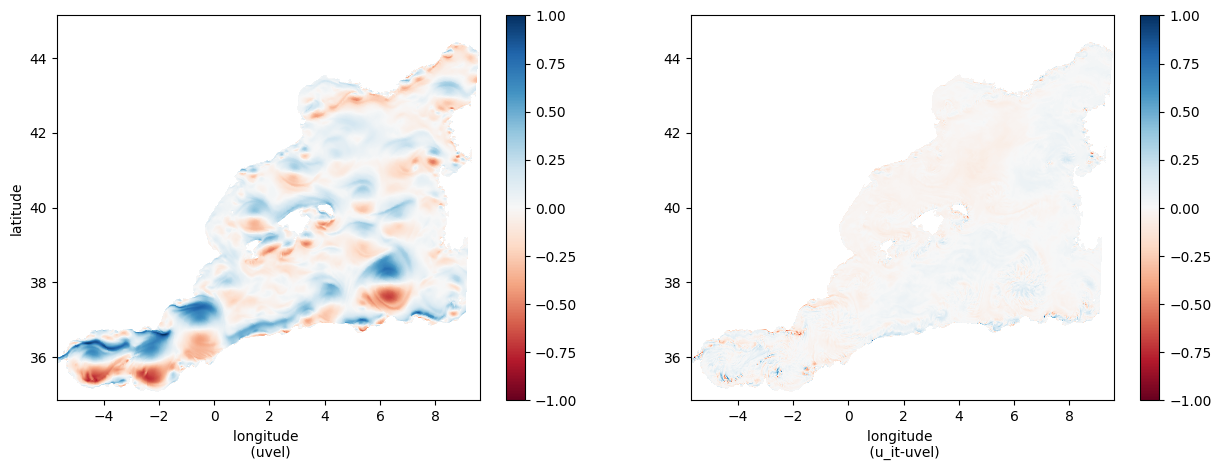

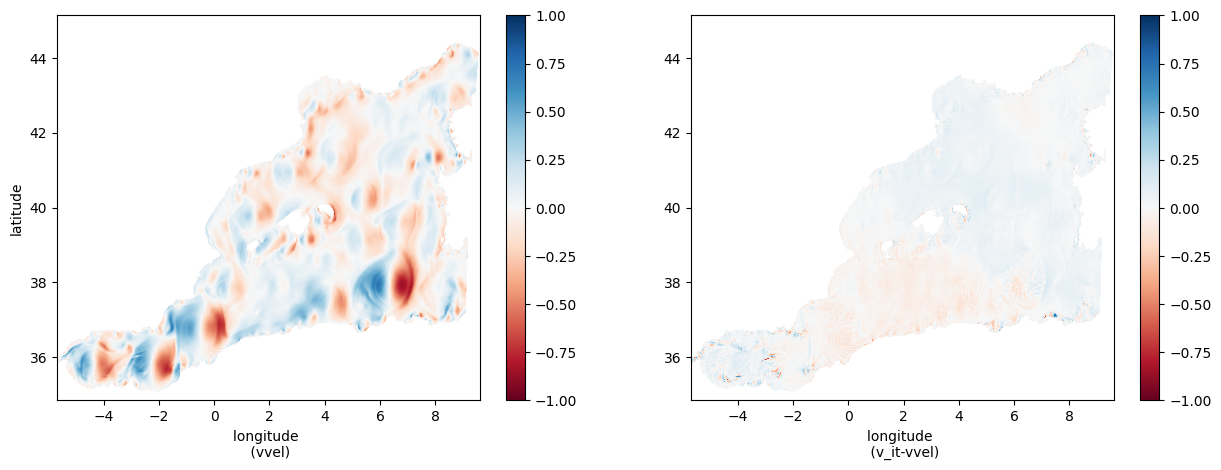

In [163]:
u_it = ma.masked_array(u_it, mask_u)
v_it = ma.masked_array(v_it, mask_v)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_it-uvel)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_it-uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_it-vvel)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_it-vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

## Plotting the iterative method

In [164]:
u_it, v_it = cyclo.iterative(u_geos.filled(0), v_geos.filled(0), lat_u, lat_v, lon_u, lon_v, coriolis_factor_u.filled(1), coriolis_factor_v.filled(1),
                             n_it=100, errsq_init="proportional", err_filter_size=3)

100%|██████████| 100/100 [00:11<00:00,  8.63it/s]


In [165]:
u_it = ma.masked_array(u_it, mask_u)
v_it = ma.masked_array(v_it, mask_v)

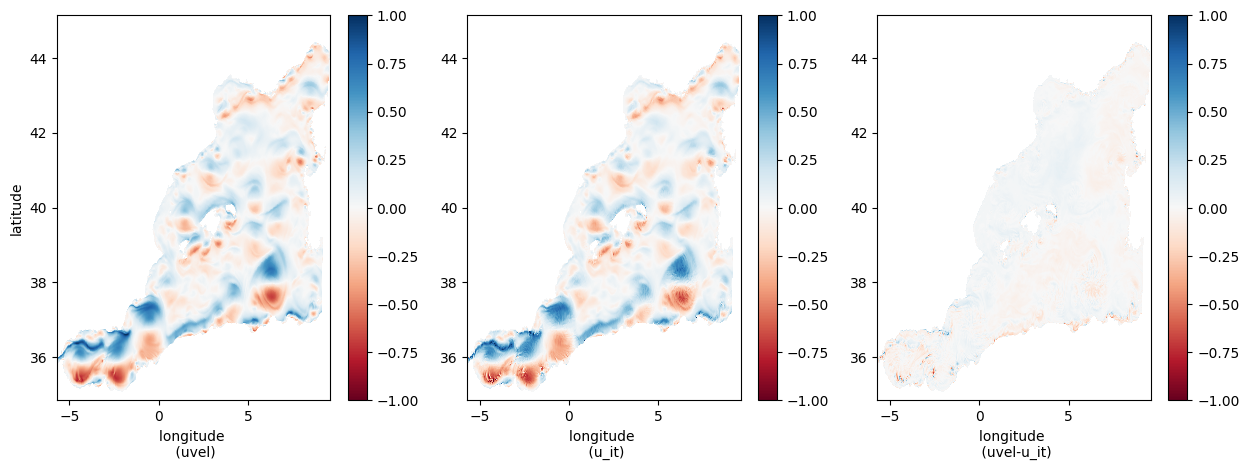

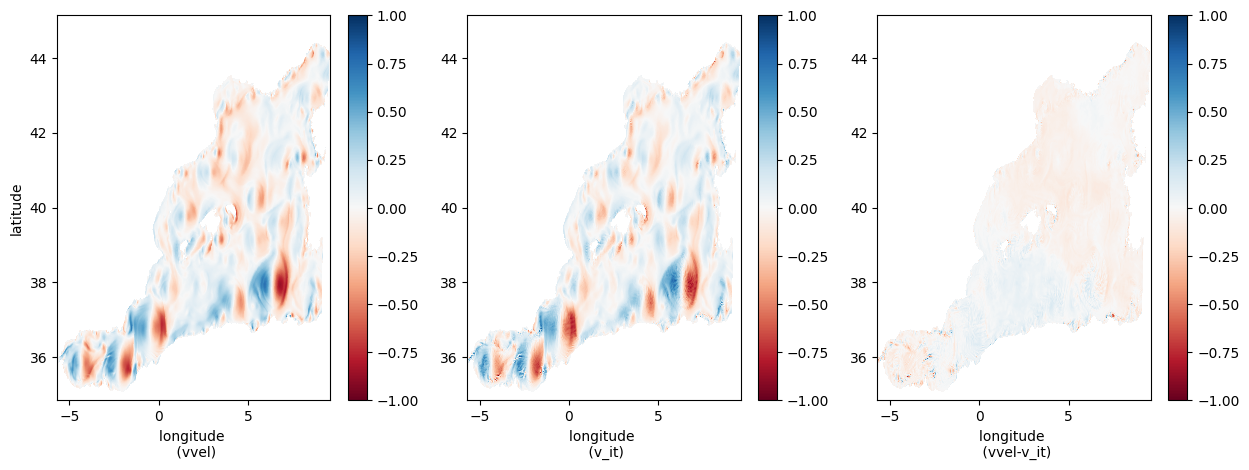

In [166]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_it)")
ax3.set_xlabel("longitude \n (uvel-u_it)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_it, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)
im = ax3.pcolormesh(lon, lat, uvel-u_it, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_it)")
ax3.set_xlabel("longitude \n (vvel-v_it)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_it, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)
im = ax3.pcolormesh(lon, lat, vvel-v_it, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax3)

## Plotting differences with the geostrophic method

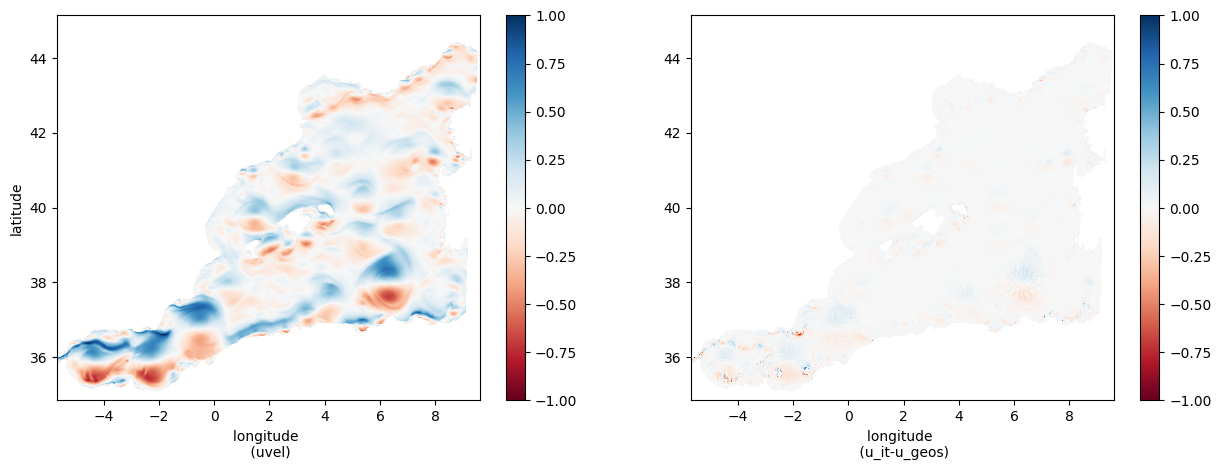

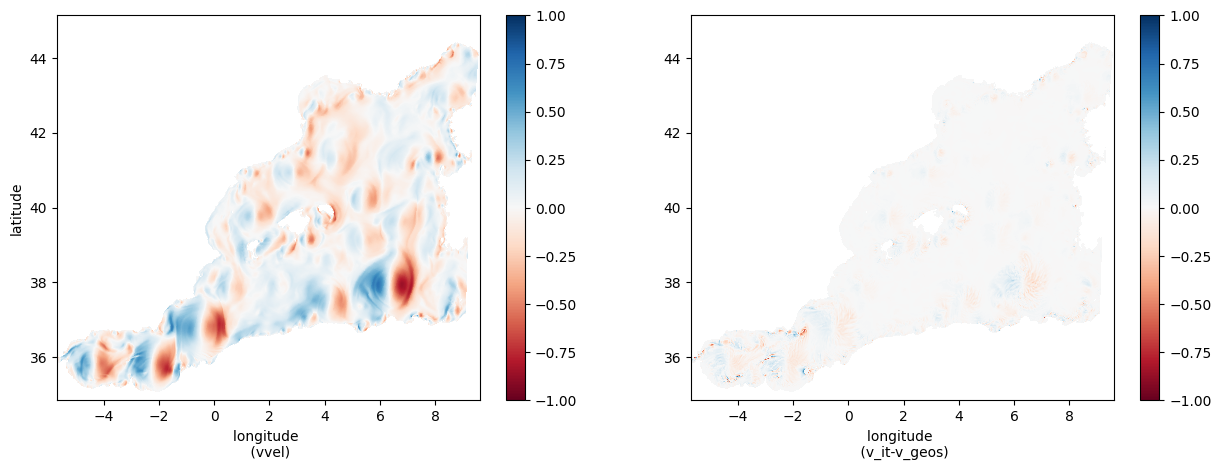

In [167]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_it-u_geos)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_it-u_geos, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_it-v_geos)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_it-v_geos, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

## Plotting differences between cyclogeostrophic methods

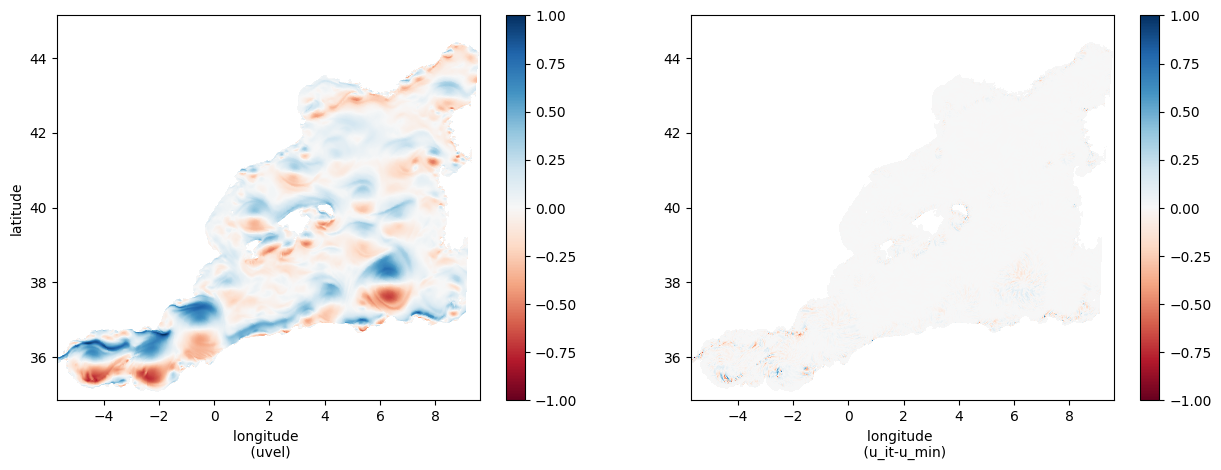

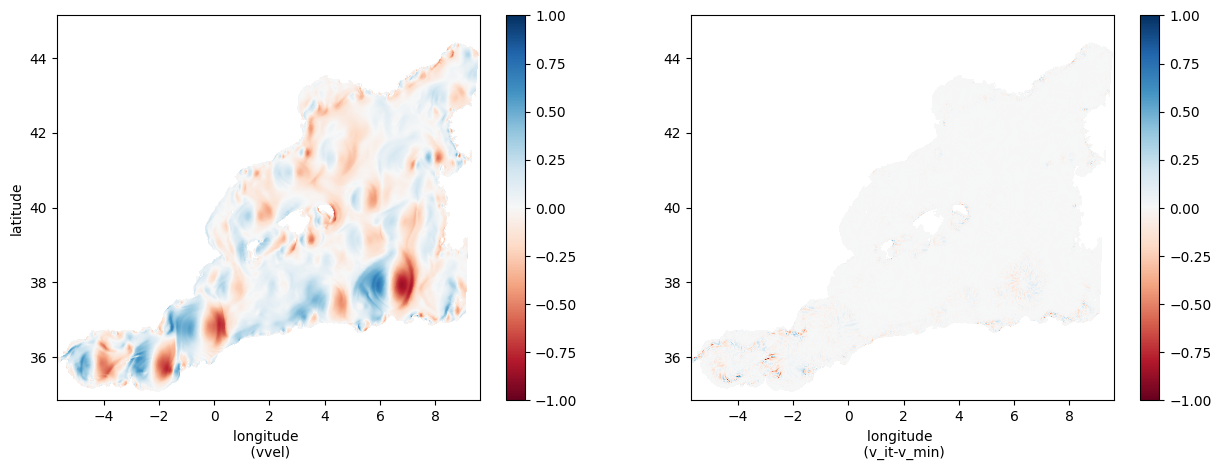

In [168]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_it-u_min)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_it-u_min, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_it-v_min)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_it-v_min, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)